# **INFERENCES**

The different models developed, tried and submitted are implemented in this notebook.
A private GitHub repository of the project is available [here](https://github.com/celine98/genhack).

## **References**

- [1] [How to Train a GAN ? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
- [2] [Practical Guide to Hyperparameters Optimization for Deep Learning Models](https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/)

___
___

## **INITIALIZATION**

### *IMPORTS*

In [138]:
from collections import OrderedDict
from IPython.display import display # to display dataframes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns # to provide plots
import time
import warnings

from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.utils as vutils

To create the ```requirement.txt``` file we use the following line of code:

In [75]:
import session_info
session_info.show()

### *DATA LOADING*

In [65]:
train_df = pd.read_csv("train.csv", index_col=0, names=["VAL1", "VAL2", "VAL3", "VAL4"])

### *DATA ANALYSIS*

In [66]:
display(train_df)

,VAL1,VAL2,VAL3,VAL4
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499
...,...,...,...,...
741,0.001938,0.008833,0.003927,0.005106
742,0.005003,0.018943,0.003057,0.001988
743,0.007683,0.001958,0.007002,0.006467
744,0.003396,0.001280,0.007621,0.001680


In [67]:
# some statistics about the dataframe values
display(train_df.describe())

,VAL1,VAL2,VAL3,VAL4
count,746.000000,746.000000,746.000000,746.000000
mean,0.013144,0.012822,0.009366,0.010788
std,0.011914,0.011712,0.009283,0.009338
min,0.000012,0.000057,0.000014,0.000067
25%,0.004761,0.003878,0.003202,0.004226
50%,0.010030,0.009423,0.006641,0.008508
75%,0.017771,0.017810,0.012354,0.014221
max,0.098709,0.088502,0.072016,0.074291


In [68]:
# correlations between values considering the features (except "count") from the previous dafaframe
train_df.describe().iloc[[i for i in range(1,8)]].corr()

,VAL1,VAL2,VAL3,VAL4
VAL1,1.000000,0.999681,0.999855,0.999907
VAL2,0.999681,1.000000,0.999487,0.999744
VAL3,0.999855,0.999487,1.000000,0.999602
VAL4,0.999907,0.999744,0.999602,1.000000


To build our models we will only work with normalized (standardised data). However when predicting our generating values we will need to un-normalize the values obtained. 

In [205]:
train_df_normalized = (train_df - train_df.mean()) / train_df.std()
display(train_df_normalized)

,VAL1,VAL2,VAL3,VAL4
0,-0.054470,-0.144799,-0.658635,-0.445863
1,-0.143146,-0.864998,-0.878996,-0.411402
2,-1.050247,-0.473369,-0.572821,-1.147324
3,0.393122,1.313894,-0.173239,-0.364766
4,0.668991,0.582378,-0.013851,0.076110
...,...,...,...,...
741,-0.940601,-0.340562,-0.585969,-0.608536
742,-0.683350,0.522619,-0.679619,-0.942462
743,-0.458394,-0.927581,-0.254648,-0.462799
744,-0.818257,-0.985469,-0.188021,-0.975389


### *DATA VISUALIZATION*

#### **Non-normalized data**

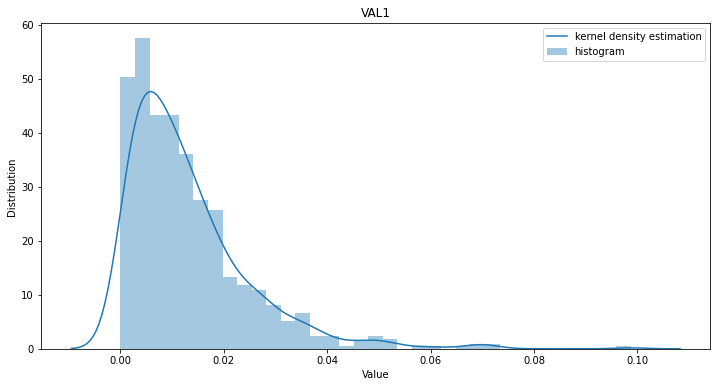

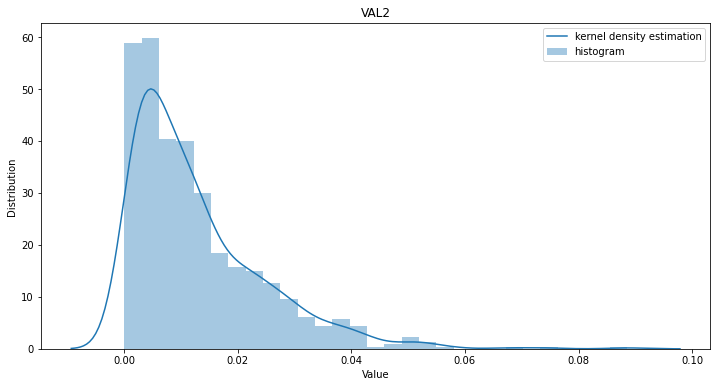

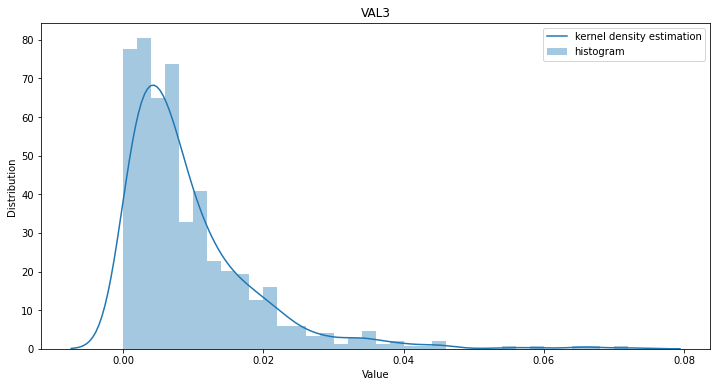

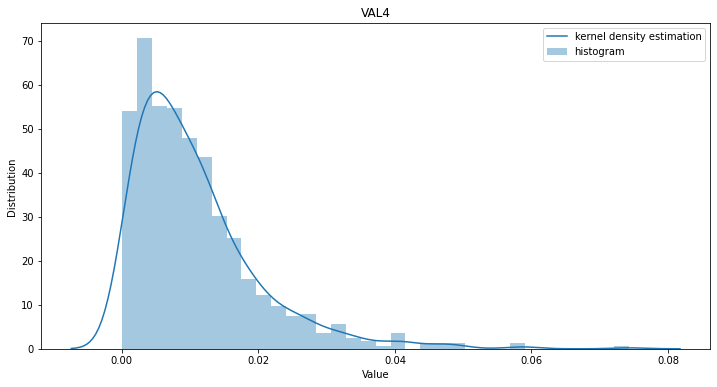

In [70]:
# plot the data distribution for each of the (not normalized) values/dimensions
warnings.simplefilter(action='ignore', category=FutureWarning)
for column in train_df.columns:
    plt.figure(figsize=(12,6))
    sns.distplot(train_df[column])
    plt.xlabel("Value")
    plt.ylabel("Distribution")
    plt.title(column)
    plt.legend(labels=["kernel density estimation", "histogram"])
    plt.show()

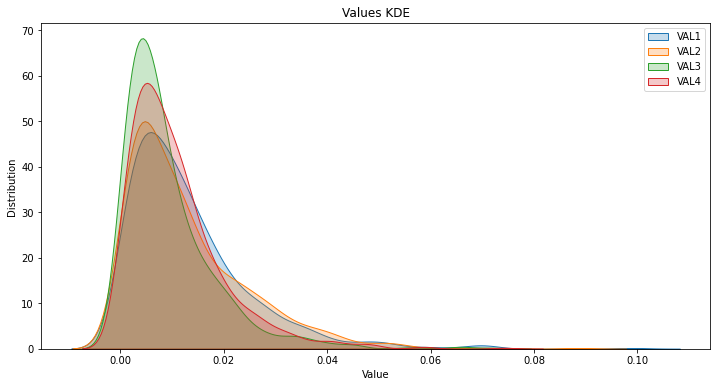

In [71]:
# plot the overlapping kernel distributions for all the (non-normalized) values
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(12,6))
for column in train_df.columns:
    sns.kdeplot(train_df[column], shade=True)
plt.xlabel("Value")
plt.ylabel("Distribution")
plt.title("Values KDE")
plt.legend(labels=["VAL1", "VAL2", "VAL3", "VAL4"])
plt.show()

#### **Normalized data**

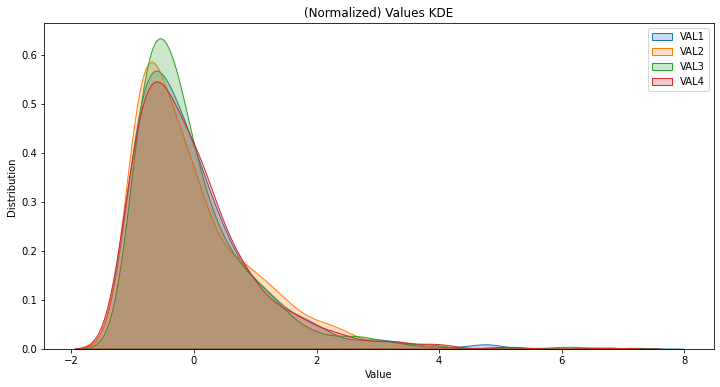

In [72]:
# plot the overlapping kernel distributions for all the (normalized) values
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(12,6))
for column in train_df_normalized.columns:
    sns.kdeplot(train_df_normalized[column], shade=True)
plt.xlabel("Value")
plt.ylabel("Distribution")
plt.title("(Normalized) Values KDE")
plt.legend(labels=["VAL1", "VAL2", "VAL3", "VAL4"])
plt.show()

### *METRICS*

In [11]:
# Anderson-Darling distance
def AD(X1,X2):

    assert (X1.shape == X2.shape)
    
    n,d = X1.shape

    u = np.zeros((n,d))
    for t in range(d):
        X2_t = list(X2[:,t])
        X2_t.sort()
        for i in range(n):
            X1_t = list(X1[:,t]) # isn't it supposed to be ordered ? (contrary to what the formula in the presentation) 
            value = 1
            u.sort()
            for j in range(n):
                if (X1_t[j] <= X2_t[i]):
                    value += 1
            u[i][t] = value/(n+2)
            if u[i][t] >= 1:
                print(0)

    W = np.zeros(d)
    for t in range(d):
        value = 0
        for i in range(n):
            value += (2*i+1) * (np.log(max(u[i][t],1e-5)) + np.log(max(1-u[n-i-1][t],1e-5)))
        W[t] = -n - (1/n)*value

    return (1/d) * np.sum(W)

In [12]:
# Absolute-Kendall-Error between two sets of the same size
def AKE(X1, X2):

    assert (X1.shape == X2.shape)

    Z1, Z2, n = [], [], X1.shape[0]

    for i in range(n):
        Z1_i, Z2_i = 0, 0
        for j in range(n):
            if i != j:
                if (np.min(X1[i]-X1[j]) > 0):
                    Z1_i += 1
                if (np.min(X2[i]-X2[j]) > 0):
                    Z2_i += 1
        Z1.append(Z1_i/(n-1))
        Z2.append(Z2_i/(n-1))
    
    Z1.sort()
    Z2.sort()

    return (1/n) * sum([abs(Z1[i]-Z2[i]) for i in range(n)])

In [13]:
# some tests
X1 = train_df.values
X2 = np.random.random(X1.shape)
print(AD(X1,X2))
print(AKE(X1,X2))

5842.157550869117
0.12510390989078216


___

## **Generative Adversarial Network**

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device: {}".format(device))

device: cuda


### *DATA*

In [110]:
output_size = 410

In [207]:
# to train the gan parameters
train = torch.tensor(train_df_normalized.values).to(device)
true_targets = torch.ones((train.shape[0],1)).to(device)

# to find "good" gan hyperparameters (explained later)
valid32 = torch.rand(train.shape[0],32).to(device)
valid64 = torch.rand(train.shape[0],64).to(device)
fake_targets = torch.zeros((train.shape[0],1))

batch_size = 64

train_dataset = data_utils.TensorDataset(train, true_targets)
train_dataloader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### *DEFINING THE NEURAL NETWORKS*

We will use feedforward neural networks and use grid search, explained in [2], to find good hyperparamters. We followed the tips from [2] to choose our models characteristics (activation functions, output function, optimizer, loss function..)

**fixed hyperparameters**

- ADAM optimizer
- Learning rate $= 5.10^{-5}$
- Leaky ReLU as activation function with $\alpha=\frac{1}{4}$

**hyperparameters to explore**:

We limit ourselves to:
- input dimension (of the random vector) among: $\{32,64\}\rightarrow 2\ values$
- number of hidden layers of the discriminator among: $\{2,3,4\}\rightarrow 2\ values$
- number of hidden layers of the generator among: $\{2,3,4\}\rightarrow 2\ values$

We want to find the network minimizing the Anderson-Darling distance and the Absolute-Kendall-Error among the $18=2\times3\times3$ possible networks.

In [225]:
class Disciminator(nn.Module):

    def __init__(self, input_size=4, nb_layer=2):

        super(Disciminator, self).__init__()

        assert (input_size == 4)
        assert (nb_layer in [2,3,4])
        
        if nb_layer == 2:
        
            self.seq = nn.Sequential(OrderedDict([
        
                ('lin1', nn.Linear(input_size, 16)),
                ('lkr1', nn.LeakyReLU(0.25)),
        
                ('lin2', nn.Linear(16, 1)),
                ('out2', nn.Sigmoid())]))
        
        elif nb_layer == 3:

            self.seq = nn.Sequential(OrderedDict([
            
                ('lin1', nn.Linear(input_size, 16)),
                ('lkr1', nn.LeakyReLU(0.25)),
            
                ('lin2', nn.Linear(16, 8)),
                ('lkr2', nn.LeakyReLU(0.125)),
            
                ('lin3', nn.Linear(8, 1)),
                ('out3', nn.Sigmoid())]))

        else:
            
            self.seq = nn.Sequential(OrderedDict([
            
                ('lin1', nn.Linear(input_size, 32)),
                ('lkr1', nn.LeakyReLU(0.25)),
            
                ('lin2', nn.Linear(32, 32)),
                ('lkr2', nn.LeakyReLU(0.2)),
            
                ('lin3', nn.Linear(32, 8)),
                ('lkr3', nn.LeakyReLU(0.125)),

                ('lin4', nn.Linear(8, 1)),
                ('out4', nn.Sigmoid())]))
    
    def forward(self, x):
        return self.seq(x)

In [226]:
class Generator(nn.Module):

    def __init__(self, input_size=32, nb_layer=2):

        super(Generator, self).__init__()

        assert (input_size in [32,64])
        assert (nb_layer in [2,3,4])
        
        if nb_layer == 2:
        
            self.seq = nn.Sequential(OrderedDict([
        
                ('lin1', nn.Linear(input_size, int(input_size//2))),
                ('lkr1', nn.LeakyReLU(0.25)),
        
                ('lin2', nn.Linear(int(input_size//2), 4)),
                ('out4', nn.Tanh())]))
        
        elif nb_layer == 3:

            self.seq = nn.Sequential(OrderedDict([
            
                ('lin1', nn.Linear(input_size, int(input_size//2))),
                ('lkr1', nn.LeakyReLU(0.25)),
            
                ('lin2', nn.Linear(int(input_size//2), int(input_size//2))),
                ('lkr2', nn.LeakyReLU(0.125)),
            
                ('lin3', nn.Linear(int(input_size//2), 4)),
                ('out3', nn.Tanh())]))

        else:
            
            self.seq = nn.Sequential(OrderedDict([
            
                ('lin1', nn.Linear(input_size, input_size)),
                ('lkr1', nn.LeakyReLU(0.25)),
            
                ('lin2', nn.Linear(input_size, int(input_size//2))),
                ('lkr2', nn.LeakyReLU(0.2)),
            
                ('lin3', nn.Linear(int(input_size//2), int(input_size//4))),
                ('lkr3', nn.LeakyReLU(0.125)),

                ('lin4', nn.Linear(int(input_size//4), 4)),
                ('out4', nn.Tanh())]))
    
    def forward(self, x):
        return self.seq(x)

### *GRID SEARCH*

#### **Fixed hyperparameters**

In [227]:
# list of (input_dimension, discriminator number of layers, generator number of layers) and list of the corresponding scores (AD & AKE)
H,S,data = [],[],[]
for i in [32,64]:
    for j in [2,3,4]:
        for k in [2,3,4]:
            H.append((i,j,k))
            S.append((0,0))
            data.append((i,j,k,0,0))
hyp_df = pd.DataFrame(data=data, columns=["input_dim", "nb_layer_d", "nb_layer_g", "ad_score", "ake_score"])        

In [228]:
criterion = nn.BCELoss()
nb_epochs = 10000

| input_dim : 32 | D nb layers : 2 | G nb layers : 2 |

epoch 0/5000 in 0.079 s


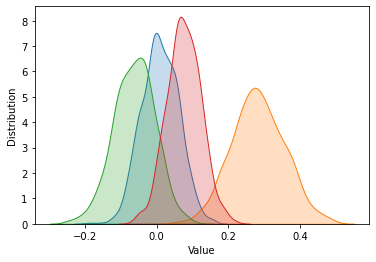

epoch 500/5000 in 28.55 s


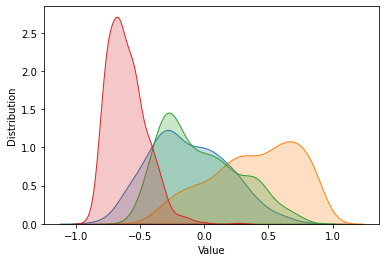

epoch 1000/5000 in 57.042 s


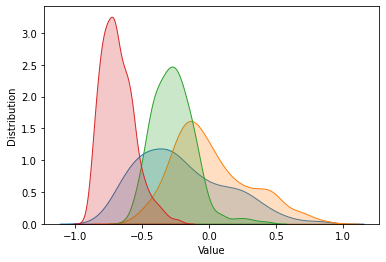

epoch 1500/5000 in 86.243 s


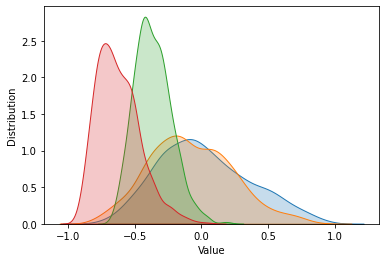

In [232]:
start = time.time()

for ih,h in enumerate(H):

    input_dim = h[0]
    nb_layer_d = h[1]
    nb_layer_g = h[2]

    print("======================================================")
    print("| input_dim : {} | D nb layers : {} | G nb layers : {} |".format(input_dim, nb_layer_d, nb_layer_g))
    print("======================================================\n")

    if (input_dim == 32):
        valid = valid32
    else:
        valid = valid64

    D = Disciminator(input_size=4, nb_layer=nb_layer_d).to(device)
    G = Generator(input_size=input_dim, nb_layer=nb_layer_g).to(device)

    optimizerD = optim.SGD(params=D.parameters(), lr=5e-2)
    optimizerG = optim.SGD(params=G.parameters(), lr=5e-2)

    start_epoch = time.time()
    
    for epoch in range(nb_epochs):

        for i,data in enumerate(train_dataloader, 0):

            # STEP 1 : Discriminator optimization step

            optimizerD.zero_grad()

            x_real, y_real = iter(train_dataloader).next()
            x_real = x_real.float()
            D_x_real = D(x_real)
            lossD_real = criterion(D_x_real, torch.ones((x_real.shape[0],1)).to(device))

            z = torch.randn(batch_size, input_dim).to(device)
            x_gen = G(z).detach()
            D_x_gen = D(x_gen)
            lossD_fake = criterion(D_x_gen, torch.zeros((x_gen.shape[0],1)).to(device))

            lossD = lossD_real + lossD_fake
            lossD.backward()
            optimizerD.step()

            # STEP 2 : Generator optimization step

            optimizerG.zero_grad()

            z = torch.randn(batch_size, input_dim).to(device)
            x_gen = G(z)
            
            D_x_gen = D(x_gen)
            lossG = criterion(D_x_gen, torch.ones((x_gen.shape[0],1)).to(device))

            lossG.backward()
            optimizerG.step()

        if (epoch)%500 == 0 or epoch==0:
            print("epoch {}/{} in {} s".format(epoch, nb_epochs, int(1000*(time.time()-start_epoch))/1000))
            x_gen = G(valid)
            x_gen_df = pd.DataFrame(x_gen.cpu().detach().numpy())
            for column in x_gen_df.columns:
                sns.kdeplot(x_gen_df[column], shade=True)
            plt.xlabel("Value")
            plt.ylabel("Distribution")
            plt.show()
        
        x_gen = G(valid)
    
    X1 = train.numpy()
    X2 = G(valid).cpu().detach().numpy()
    ad = AD(X1,X2)
    ake = AKE(X1,X2)
    S[ih] = (ad,ake)
    hyp_df.iloc[ih]["ad_score"] = ad
    hyp_df.iloc[ih]["ake_score"] = ake
    hyp_df.to_csv("hyperparameters.csv", index=None)

    print("hyperparameters: {} --> scores: {}".format(h,S[-1]))

    print("[{} \% of the grid explored in {} s]".format(int(10000*(ih+1)/len(H))/100, int(100*(time.time()-start))/100))

### *RESULTS ANALYSIS*

In [214]:
S_AD = [S[i][0] for i in range(len(S))]
S_AKE = [S[i][1] for i in range(len(S))]
ad_index = S_AD.index(min(S_AD))
ake_index = S_AKE.index(min(S_AKE))

best_ad_h, best_ad_s = H[ad_index], S[ad_index]
best_ake_h, best_ake_s = H[ad_index], S[ad_index]

print(best_ad_h, best_ad_s)
print(best_ake_h, best_ake_s)

(32, 4, 4) (0, 0)
(32, 4, 4) (0, 0)
